In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import numpy as np

In [4]:
client_data = "../data/clean/clean_client_data.csv"
analysis_data = "../data/clean/data_extra_col.csv"


In [5]:
client_df = pd.read_csv(client_data)
analysis_df = pd.read_csv(analysis_data)


In [6]:
analysis_df[analysis_df['step_proceeds']==True].pivot_table(index='process_step',
                                                            columns='Variation',
                                                            values=['step_duration'],
                                                            aggfunc='mean').round(2)

step_duration       
Variation          Control   Test
process_step                     
start                21.07  11.72
step_1               25.02  28.58
step_2               72.49  70.71
step_3               86.53  73.40

In [110]:
step_rate_pivot = analysis_df.pivot_table(index='process_step',
                                         columns='Variation',
                                         values=['step_proceeds'],
                                         aggfunc='mean').round(4)


step_rate_pivot[('step_proceeds', 'Test')] = 100 * step_rate_pivot[('step_proceeds', 'Test')]
step_rate_pivot[('step_proceeds', 'Control')] = 100 * step_rate_pivot[('step_proceeds', 'Control')]
step_rate_pivot['change_index'] = (((step_rate_pivot[('step_proceeds', 'Test')] / (step_rate_pivot[(('step_proceeds', 'Control'))])))).round(4)
step_rate_pivot['change_pct'] = (100*(step_rate_pivot['change_index']-1)).round(2)

display(step_rate_pivot)

print(f"Overall step success rate improvement: {(100*(step_rate_pivot['change_index'].product()-1)).round(2)}%")



step_proceeds        change_index change_pct
Variation          Control   Test                        
process_step                                             
confirm               0.00   0.00          NaN        NaN
start                64.05  66.12       1.0323       3.23
step_1               77.28  76.32       0.9876      -1.24
step_2               82.75  80.19       0.9691      -3.09
step_3               70.41  75.00       1.0652       6.52

Overall step success rate improvement: 5.24%


In [112]:
analysis_df.columns

Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time',
       'Variation', 'visit_final_step', 'step_duration', 'step_proceeds',
       'step_error', 'successful_visit'],
      dtype='object')

In [114]:
step_remain_pivot = analysis_df.pivot_table(index='process_step',
                                            columns='Variation',
                                            values=['visit_final_step'],
                                            aggfunc=['mean', 'count']).round(4)


step_remain_pivot.columns = step_remain_pivot.columns.droplevel(1)

display(step_remain_pivot)

control_confirm = step_remain_pivot[('count','Control')].loc['confirm']
control_start = step_remain_pivot[('count','Control')].loc['start']
test_confirm = step_remain_pivot[('count','Test')].loc['confirm']
test_start = step_remain_pivot[('count','Test')].loc['start']

control_success = control_confirm / control_start
test_success = test_confirm / test_start

success_improvement = (test_success/control_success-1).round(3)

print(f"Control group visits {control_success}")

print(f"Success rate improved by {100*success_improvement}%")

mean           count       
Variation    Control    Test Control   Test
process_step                               
confirm       0.9678  0.9890   11779  15512
start         0.3576  0.3339   24677  23881
step_1        0.1417  0.1003   20206  22823
step_2        0.0682  0.0522   17897  19121
step_3        0.1046  0.0779   15619  16170

Control group visits 0.477327065688698
Success rate improved by 36.1%


In [116]:
def successful_visit_durations(df=analysis_df):
    experiment_df = df.copy()
    success_df = experiment_df[experiment_df['successful_visit']==True]
    duration_df = success_df[(success_df['process_step']=='start') | (success_df['process_step']=='confirm')]
    duration_df = duration_df[['visit_id', 'Variation', 'process_step', 'date_time']]

    duration_df_pivot = duration_df.pivot_table(index=['Variation', 'visit_id'],
                                            columns='process_step',
                                            values='date_time',
                                            aggfunc='first')

    duration_df_pivot['confirm'] = pd.to_datetime(duration_df_pivot['confirm'])
    duration_df_pivot['start'] = pd.to_datetime(duration_df_pivot['start'])
    duration_df_pivot['duration'] = (duration_df_pivot['confirm'] - duration_df_pivot['start']).dt.total_seconds()

    success_durations = duration_df_pivot.reset_index()[['Variation', 'visit_id', 'duration']]

    results = success_durations.pivot_table(index=['Variation'],
                                            values='duration',
                                            aggfunc='mean').round(2)

    result_dict = results.to_dict()['duration']
    
    return(result_dict)

In [118]:
def visit_df(df=analysis_df):

    piv_df = df.pivot_table(
        index=['visit_id', 'client_id', 'Variation','successful_visit'],
        values=['step_duration', 'process_step'],
        aggfunc={
            'step_duration': 'sum',
            'process_step': 'count',
        }).round(2)
    
    results = piv_df.reset_index()
    results = results.rename(columns={'process_step': 'step_count', 'step_duration': 'visit_duration'})

    piv_df2 = analysis_df.pivot_table(
        index='visit_id', 
        columns='process_step', 
        aggfunc='size', 
        fill_value=0)

    merged_piv_df = pd.merge(results, piv_df2, on='visit_id', how='outer')
    
    return(merged_piv_df)

In [120]:
visit_df = visit_df(analysis_df)

visit_df.to_csv('../data/clean/visit_data.csv', index=False)

In [121]:
visit_piv = visit_df.pivot_table(
                index='Variation',
                values=['visit_id', 'confirm', 'successful_visit'],
                aggfunc={
                    'visit_id': 'count',
                    'confirm': 'sum',
                    'successful_visit': 'sum'
                })

visit_piv = visit_piv.rename(columns={'visit_id': 'visit_count', 'confirm': 'confirmed_visits', 'successful_visit': 'full_success_visits'})

visit_piv['full_success_visits'] = (100* visit_piv['full_success_visits'] / visit_piv['visit_count']).round(2)
visit_piv['confirmed_visits'] = (100* visit_piv['confirmed_visits'] / visit_piv['visit_count']).round(2)

visit_piv = visit_piv[['confirmed_visits', 'full_success_visits']]

visit_piv


confirmed_visits  full_success_visits
Variation                                       
Control               45.67                40.91
Test                  55.95                42.10

In [124]:
visit_piv['full_success_visits']['Test']/visit_piv['full_success_visits']['Control']

1.0290882424835004

In [126]:
visit_piv['confirmed_visits']['Test']/visit_piv['confirmed_visits']['Control']

1.2250930589008102

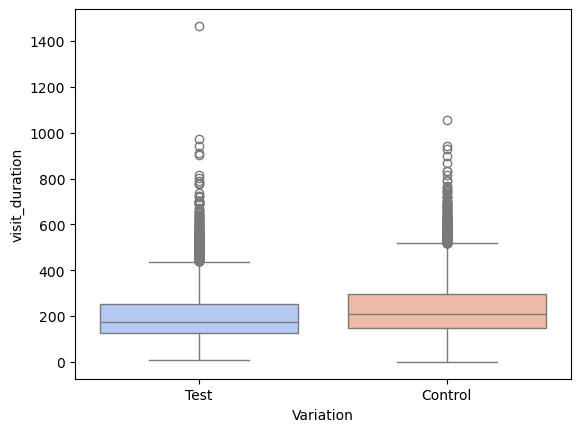

In [173]:
sns.boxplot(data=visit_df[visit_df['successful_visit']==True], y='visit_duration', x='Variation', hue='Variation', palette="coolwarm", legend=False);

plt.savefig("../figures/boxplot.png")

In [128]:
def pivot_df(df=analysis_df):
    df['other_issue'] = (df['step_proceeds']==False) & (df['step_error']==False) & (df['visit_final_step']==False)
    
    piv_df = df.pivot_table(index='process_step',
                columns='Variation',
                values=['step_duration', 'step_proceeds', 'visit_final_step', 'step_error', 'other_issue', 'visit_id'],
                aggfunc={
                    'step_duration': 'mean',
                    'step_proceeds': 'mean',
                    'visit_final_step': 'mean',
                    'step_error': 'mean',
                    'other_issue': 'mean',
                    'visit_id' : 'nunique'
                }).round(2)
    
    piv_df = piv_df[['step_duration', 'step_proceeds', 'visit_final_step', 'step_error', 'other_issue', 'visit_id' ]].sort_values(by=('visit_id', 'Test'), ascending=False)
    
    return(piv_df)

In [130]:
def visit_success_rate(df=analysis_df):

    piv_df = df.pivot_table(
        index='Variation',
        columns = 'successful_visit',
        values='visit_id',
        aggfunc='nunique')

    results = piv_df.reset_index()
    results = results.rename(columns={'visit_id': 'visit_count'})
    results['success_rate'] = round(100 * results[True] / (results[True] + results[False]),2)
    results.set_index('Variation', inplace=True)
   
    result_dict = results.to_dict()['success_rate']

    return(result_dict)

In [132]:
successful_visit_durations(analysis_df)

{'Control': 219.97, 'Test': 190.42}

In [134]:
visit_success_rate(analysis_df)

{'Control': 40.83, 'Test': 42.04}

In [136]:
duration_imp = round(100 * (successful_visit_durations(analysis_df)['Test'] / successful_visit_durations(analysis_df)['Control'] -1),2)
success_imp = round(100 * (visit_success_rate(analysis_df)['Test'] / visit_success_rate(analysis_df)['Control'] -1),2)

print(f"Visit success rate changed: {success_imp}%")
print(f"Visit average duration changed: {duration_imp}%")

Visit success rate changed: 2.96%
Visit average duration changed: -13.43%


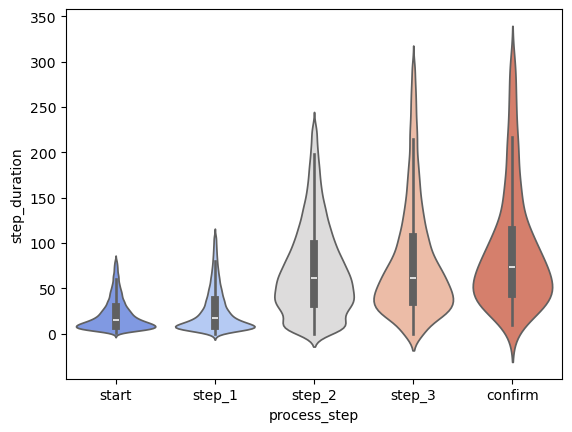

In [138]:
sns.violinplot(data=analysis_df[(analysis_df['Variation']=='Control') & (analysis_df['step_duration']<300)], y='step_duration', x='process_step', palette="coolwarm", hue='process_step', legend=False);

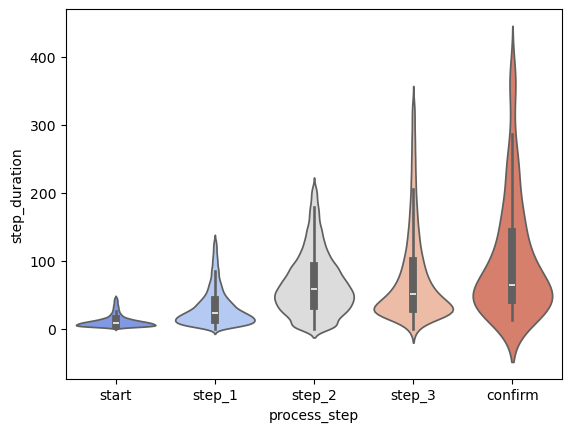

In [139]:
sns.violinplot(data=analysis_df[analysis_df['Variation']=='Test'], y='step_duration', x='process_step', palette="coolwarm", hue='process_step', legend=False);

In [140]:
pivot_df()

step_duration         step_proceeds       visit_final_step        \
Variation          Control    Test       Control  Test          Control  Test   
process_step                                                                    
start                21.07   11.75          0.64  0.66             0.36  0.33   
step_1               25.68   31.63          0.77  0.76             0.14  0.10   
step_2               70.59   66.72          0.83  0.80             0.07  0.05   
confirm             104.79  101.92          0.00  0.00             0.97  0.99   
step_3               81.35   76.63          0.70  0.75             0.10  0.08   

             step_error       other_issue       visit_id         
Variation       Control  Test     Control  Test  Control   Test  
process_step                                                     
start              0.00  0.00        0.00  0.00    24677  23881  
step_1             0.05  0.09        0.04  0.04    17351  19012  
step_2             0.05  0.08        0.06  0.06    14568  16261  
confirm            0.00  0.00        0.03  0.01    11779  15512  
step_3             0.10  0.07        0.09  0.10    13083  14619

In [141]:
error_visit_ids = list(analysis_df[(analysis_df['step_error'] == True)]['visit_id'].unique())
non_proceed_visit_ids = list(analysis_df[(analysis_df['step_proceeds'] == False) & (analysis_df['visit_final_step'] == False)]['visit_id'].unique())
total_visit_ids = list(analysis_df['visit_id'].unique())

In [142]:
# What proportion of visits have an error (go back to the previous step)
round(100 * len(error_visit_ids) / len(total_visit_ids),2)

10.7

In [143]:
# What proportion of visits had steps that didn't proceed as expected
round(100 * len(non_proceed_visit_ids) / len(total_visit_ids),2)

18.37

In [144]:
#What share of steps proceed / end the process / result in going back a step
step_proceeds_df = analysis_df[analysis_df['step_proceeds'] == True]
step_proceeds = analysis_df[['step_proceeds','visit_final_step', 'step_error']].mean() * 100
step_proceeds

step_proceeds       62.816954
visit_final_step    28.667715
step_error           4.355702
dtype: float64

In [145]:
#Set the hypothesis

#H0: control completion rate == test completion rate
#H1: control completion rate != test completion rate

alpha = 0.05

In [146]:
import numpy as np

# Assuming 'results' is the dataframe with the given data
test_visits = visit_df[visit_df['Variation'] == 'Test']
control_visits = visit_df[visit_df['Variation'] == 'Control']

# Calculate the number of successes (True values for 'successful_visit')
test_success = test_visits[test_visits['successful_visit'] == True].shape[0]
test_total = test_visits.shape[0]

control_success = control_visits[control_visits['successful_visit'] == True].shape[0]
control_total = control_visits.shape[0]

# Calculate the completion rates (proportions)
test_success_rate = test_success / test_total
control_success_rate = control_success / control_total

print(f"Test Completion Rate: {test_success_rate:.4f}")
print(f"Control Completion Rate: {control_success_rate:.4f}")

Test Completion Rate: 0.4210
Control Completion Rate: 0.4091


In [147]:
#Samples:
test_samples = [np.mean(np.random.choice(test_visits['successful_visit'], 100))for _ in range(500)]
control_samples = [np.mean(np.random.choice(control_visits['successful_visit'], 100))for _ in range(500)]

<function matplotlib.pyplot.show(close=None, block=None)>

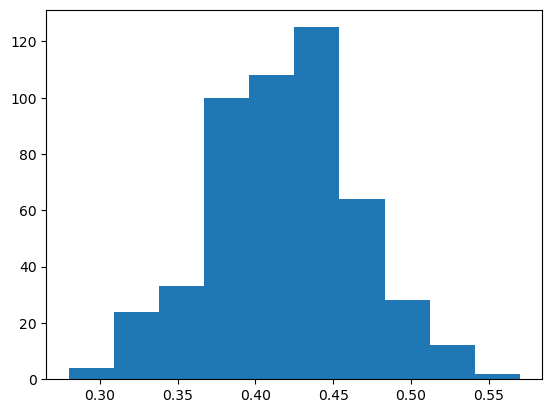

In [148]:
plt.hist(test_samples)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

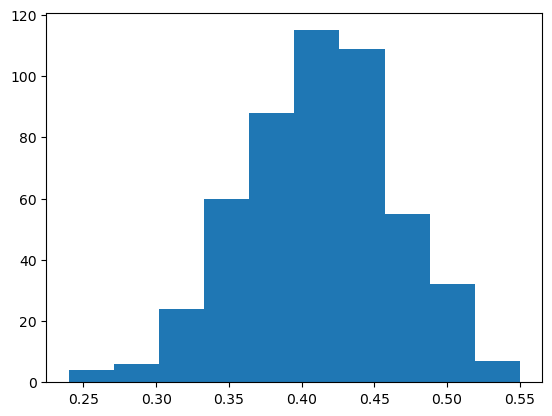

In [149]:
plt.hist(control_samples)
plt.show

In [150]:
st.ttest_ind(test_samples, control_samples, equal_var=False, alternative="two-sided")


TtestResult(statistic=2.431459630712606, pvalue=0.015213731691638564, df=995.2494268161577)

In [151]:
#p-value is less than alpha (0.05)

In [152]:
success_df = visit_df[visit_df['successful_visit']==True]

In [153]:
success_df.head()

visit_id  client_id Variation  successful_visit  \
1    100019538_17884295066_43909    7338123      Test              True   
2   100022086_87870757897_149620    2478628      Test              True   
6    10006594_66157970412_679648    3479519   Control              True   
10  100173292_91322748906_143563    8631696      Test              True   
13  100254180_47139859079_984581     984526   Control              True   

    step_count  visit_duration  confirm  start  step_1  step_2  step_3  
1            9           226.0        1      1       4       2       1  
2            5           180.0        1      1       1       1       1  
6            7           354.0        1      1       1       1       3  
10           5            95.0        1      1       1       1       1  
13           5           341.0        1      1       1       1       1

In [154]:
test_success_durations = success_df[success_df['Variation'] == 'Test']['visit_duration']
control_success_durations = success_df[success_df['Variation'] == 'Control']['visit_duration']

# H0 test_success_duration mean != control_success_duration mean 

In [155]:
st.ttest_ind(test_success_durations, control_success_durations, equal_var=False, alternative="two-sided")

TtestResult(statistic=-21.336020097650984, pvalue=5.591541239331568e-100, df=21708.833506331393)

In [156]:
#p-value is less than alpha (0.05)

<function matplotlib.pyplot.show(close=None, block=None)>

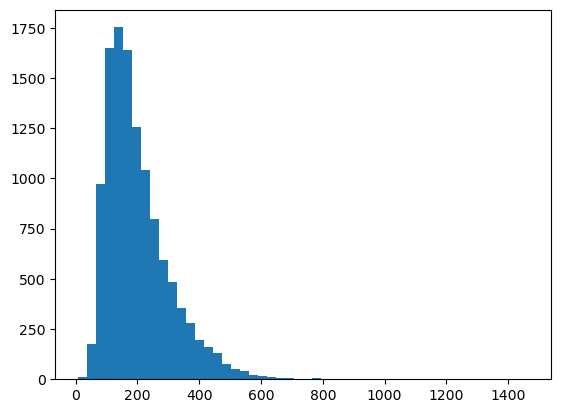

In [157]:
plt.hist(test_success_durations, bins=50)
plt.show

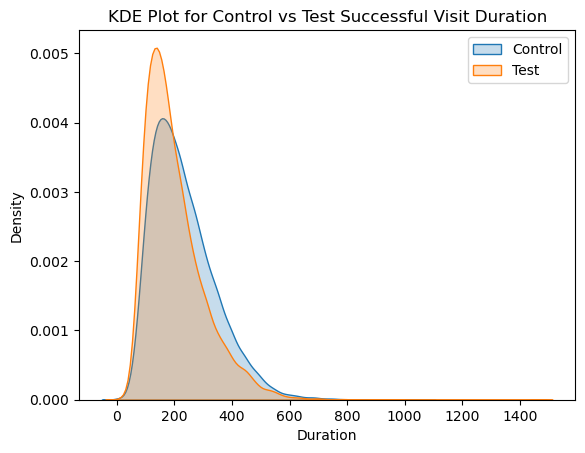

In [175]:
sns.kdeplot(control_success_durations, label='Control', fill=True)
sns.kdeplot(test_success_durations, label='Test', fill=True)

plt.xlabel('Duration')
plt.ylabel('Density')
plt.title('KDE Plot for Control vs Test Successful Visit Duration')
plt.legend()
plt.show
plt.savefig("../figures/visit_duration_control_vs_test.png", transparent=True)

In [159]:
test_success_steps = success_df[success_df['Variation'] == 'Test']['step_count']
control_success_steps = success_df[success_df['Variation'] == 'Control']['step_count']

# H0 test_success_duration mean != control_success_duration mean 

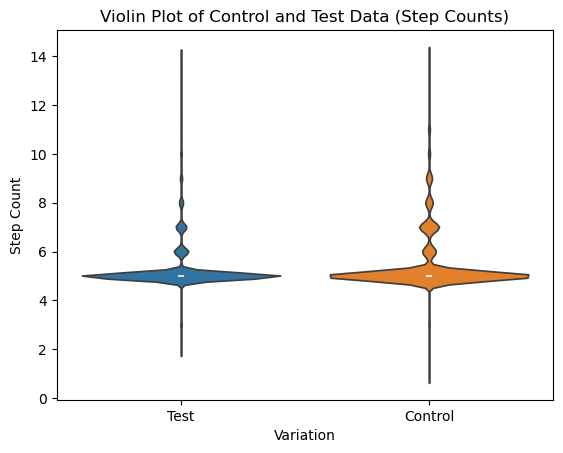

In [160]:
# Plotting the normalized histograms
# Combine the datasets into a single DataFrame for easier plotting
import pandas as pd

limit = success_df[success_df['step_count']< 15]
    
    # Create the violin plot
sns.violinplot(x='Variation', y='step_count', hue='Variation', data=limit)

# Adding labels and title
plt.ylabel('Step Count')
plt.title('Violin Plot of Control and Test Data (Step Counts)')

# Show the plot
plt.show()

In [161]:
success_df['over_4_steps'] = success_df['step_count'] > 4

C:\Users\olgeo\AppData\Local\Temp\ipykernel_15952\893607091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['over_4_steps'] = success_df['step_count'] > 4


In [162]:
success_df.pivot_table(index='Variation',
                columns='over_4_steps',
                values='visit_id',
                aggfunc='count')

over_4_steps  False  True 
Variation                 
Control          56  10557
Test             74  11657

In [163]:
analysis_df.head()

client_id             visitor_id                      visit_id  \
0        555  402506806_56087378777  637149525_38041617439_716659   
1        555  402506806_56087378777  637149525_38041617439_716659   
2        555  402506806_56087378777  637149525_38041617439_716659   
3        555  402506806_56087378777  637149525_38041617439_716659   
4        555  402506806_56087378777  637149525_38041617439_716659   

  process_step            date_time Variation  visit_final_step  \
0        start  2017-04-15 12:57:56      Test             False   
1       step_1  2017-04-15 12:58:03      Test             False   
2       step_2  2017-04-15 12:58:35      Test             False   
3       step_3  2017-04-15 13:00:14      Test             False   
4      confirm  2017-04-15 13:00:34      Test              True   

   step_duration  step_proceeds  step_error  successful_visit  other_issue  
0            7.0           True       False              True        False  
1           32.0           True       False              True        False  
2           99.0           True       False              True        False  
3           20.0           True       False              True        False  
4            NaN          False       False              True        False

In [177]:
test = analysis_df.copy()
non_success_df = test[test['successful_visit']==False]

piv_df = non_success_df.pivot_table(index='process_step',
                                   columns='Variation',
                                   values='visit_final_step',
                                   aggfunc="mean")

piv_df
#piv_df[~piv_df['process_step']=='confirm']

Variation      Control      Test
process_step                    
confirm       0.894395  0.979518
start         0.624602  0.652217
step_1        0.319206  0.234841
step_2        0.242829  0.163255
step_3        0.508371  0.325377

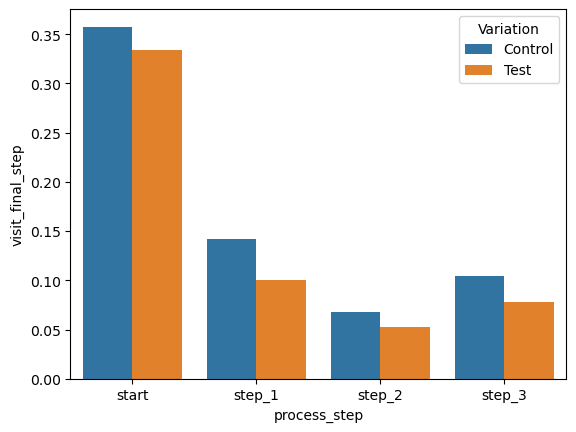

In [179]:
df = analysis_df[analysis_df['process_step']!='confirm']

piv_df = df.pivot_table(index='process_step',
                       columns='Variation',
                       values='visit_final_step',
                       aggfunc="mean").reset_index()

melt_df = piv_df.melt(id_vars='process_step',
                     value_vars = ['Control', 'Test'],
                     var_name = 'Variation',
                     value_name = 'visit_final_step')

sns.barplot(data=melt_df, x='process_step', y='visit_final_step', hue='Variation');

In [180]:
client_df.head()

client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts  \
0        169            21.0             262.0      47.5     M        2.0   
1        555             3.0              46.0      29.5     U        2.0   
2        647            12.0             151.0      57.5     M        2.0   
3        722            11.0             143.0      59.5     F        2.0   
4        934             9.0             109.0      51.0     F        2.0   

         bal  calls_6_mnth  logons_6_mnth Variation balance_quartile  
0  501570.72           4.0            4.0       NaN               Q4  
1   25454.66           2.0            6.0      Test               Q1  
2   30525.80           0.0            4.0      Test               Q1  
3   22466.17           1.0            1.0       NaN               Q1  
4   32522.88           0.0            3.0      Test               Q1

In [181]:
analysis_client = pd.merge(analysis_df, client_df, on='client_id', how='left')

In [184]:
analysis_client.drop(columns=['Variation_y'],axis=1,inplace=True)

In [186]:
analysis_client.rename(columns={'Variation_x' : 'Variation'}, inplace=True)

In [188]:
analysis_client.head()

client_id             visitor_id                      visit_id  \
0        555  402506806_56087378777  637149525_38041617439_716659   
1        555  402506806_56087378777  637149525_38041617439_716659   
2        555  402506806_56087378777  637149525_38041617439_716659   
3        555  402506806_56087378777  637149525_38041617439_716659   
4        555  402506806_56087378777  637149525_38041617439_716659   

  process_step            date_time Variation  visit_final_step  \
0        start  2017-04-15 12:57:56      Test             False   
1       step_1  2017-04-15 12:58:03      Test             False   
2       step_2  2017-04-15 12:58:35      Test             False   
3       step_3  2017-04-15 13:00:14      Test             False   
4      confirm  2017-04-15 13:00:34      Test              True   

   step_duration  step_proceeds  step_error  ...  other_issue  clnt_tenure_yr  \
0            7.0           True       False  ...        False             3.0   
1           32.0           True       False  ...        False             3.0   
2           99.0           True       False  ...        False             3.0   
3           20.0           True       False  ...        False             3.0   
4            NaN          False       False  ...        False             3.0   

   clnt_tenure_mnth  clnt_age  gendr num_accts       bal  calls_6_mnth  \
0              46.0      29.5      U       2.0  25454.66           2.0   
1              46.0      29.5      U       2.0  25454.66           2.0   
2              46.0      29.5      U       2.0  25454.66           2.0   
3              46.0      29.5      U       2.0  25454.66           2.0   
4              46.0      29.5      U       2.0  25454.66           2.0   

   logons_6_mnth  balance_quartile  
0            6.0                Q1  
1            6.0                Q1  
2            6.0                Q1  
3            6.0                Q1  
4            6.0                Q1  

[5 rows x 21 columns]

In [190]:
visit_id_df = analysis_df[['visit_id', 'client_id']].drop_duplicates()

In [205]:
visit_client = pd.merge(visit_df, visit_id_df, on=['visit_id','client_id'], how='left')
visit_client.head()

visit_id  client_id Variation  successful_visit  \
0  100012776_37918976071_457913    3561384      Test             False   
1   100019538_17884295066_43909    7338123      Test              True   
2  100022086_87870757897_149620    2478628      Test              True   
3  100030127_47967100085_936361     105007   Control             False   
4  100037962_47432393712_705583    5623007   Control             False   

   step_count  visit_duration  confirm  start  step_1  step_2  step_3  
0           1             0.0        1      0       0       0       0  
1           9           226.0        1      1       4       2       1  
2           5           180.0        1      1       1       1       1  
3           1             0.0        0      1       0       0       0  
4           2             8.0        0      1       1       0       0

In [207]:
visit_client = pd.merge(visit_client, client_df, on='client_id', how='left')
visit_client.head()

visit_id  client_id Variation_x  successful_visit  \
0  100012776_37918976071_457913    3561384        Test             False   
1   100019538_17884295066_43909    7338123        Test              True   
2  100022086_87870757897_149620    2478628        Test              True   
3  100030127_47967100085_936361     105007     Control             False   
4  100037962_47432393712_705583    5623007     Control             False   

   step_count  visit_duration  confirm  start  step_1  step_2  ...  \
0           1             0.0        1      0       0       0  ...   
1           9           226.0        1      1       4       2  ...   
2           5           180.0        1      1       1       1  ...   
3           1             0.0        0      1       0       0  ...   
4           2             8.0        0      1       1       0  ...   

   clnt_tenure_yr  clnt_tenure_mnth  clnt_age  gendr num_accts        bal  \
0             4.0              56.0      59.5      U       2.0   63130.44   
1             7.0              88.0      23.5      M       2.0   26436.73   
2            16.0             198.0      47.0      F       2.0   32456.28   
3             9.0             118.0      35.0      F       2.0   34897.47   
4            16.0             202.0      78.0      M       2.0  146827.14   

   calls_6_mnth  logons_6_mnth  Variation_y balance_quartile  
0           6.0            9.0         Test               Q2  
1           6.0            9.0         Test               Q1  
2           2.0            5.0         Test               Q1  
3           3.0            6.0      Control               Q1  
4           5.0            8.0      Control               Q4  

[5 rows x 21 columns]

In [209]:
visit_client.columns

Index(['visit_id', 'client_id', 'Variation_x', 'successful_visit',
       'step_count', 'visit_duration', 'confirm', 'start', 'step_1', 'step_2',
       'step_3', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth', 'Variation_y',
       'balance_quartile'],
      dtype='object')

In [211]:
visit_client.drop(columns=['Variation_y'],axis=1,inplace=True)
visit_client.rename(columns={'Variation_x' : 'Variation'}, inplace=True)

In [213]:
visit_client.head()

visit_id  client_id Variation  successful_visit  \
0  100012776_37918976071_457913    3561384      Test             False   
1   100019538_17884295066_43909    7338123      Test              True   
2  100022086_87870757897_149620    2478628      Test              True   
3  100030127_47967100085_936361     105007   Control             False   
4  100037962_47432393712_705583    5623007   Control             False   

   step_count  visit_duration  confirm  start  step_1  step_2  step_3  \
0           1             0.0        1      0       0       0       0   
1           9           226.0        1      1       4       2       1   
2           5           180.0        1      1       1       1       1   
3           1             0.0        0      1       0       0       0   
4           2             8.0        0      1       1       0       0   

   clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts        bal  \
0             4.0              56.0      59.5     U        2.0   63130.44   
1             7.0              88.0      23.5     M        2.0   26436.73   
2            16.0             198.0      47.0     F        2.0   32456.28   
3             9.0             118.0      35.0     F        2.0   34897.47   
4            16.0             202.0      78.0     M        2.0  146827.14   

   calls_6_mnth  logons_6_mnth balance_quartile  
0           6.0            9.0               Q2  
1           6.0            9.0               Q1  
2           2.0            5.0               Q1  
3           3.0            6.0               Q1  
4           5.0            8.0               Q4

In [215]:
# Is gendr similar between Test and Control

crosstab_res = pd.crosstab(visit_client['Variation'], visit_client['gendr'])

from scipy.stats import chi2_contingency

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_res)

display(crosstab_res)
print(chi2_statistic, chi2_p_value)

# Not significant association between these values

gendr         F     M     U  X
Variation                     
Control    8387  8880  8673  0
Test       9066  9404  9380  1

2.233181447740982 0.5254422662511531


In [ ]:
# Is success_rate similar between Test and Control

crosstab_res = pd.crosstab(visit_client['Variation'], visit_client['successful_visit'])

from scipy.stats import chi2_contingency

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_res)

display(crosstab_res)
print(chi2_statistic, chi2_p_value)

# There is significant association between these values

In [227]:
visit_client.columns

Index(['visit_id', 'client_id', 'Variation', 'successful_visit', 'step_count',
       'visit_duration', 'confirm', 'start', 'step_1', 'step_2', 'step_3',
       'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts',
       'bal', 'calls_6_mnth', 'logons_6_mnth', 'balance_quartile'],
      dtype='object')

In [231]:
# Is age similar between Test and Control
#Set the hypothesis

#H0: mu test == mu control
#H1: mu test != mu control

import scipy.stats as st

# Define alpha (significance level)
alpha = 0.05

# Filter the data for Test and Control groups
df_test = visit_client[visit_client['Variation'] == 'Test'][['step_count',
       'visit_duration',
       'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'num_accts',
       'bal', 'calls_6_mnth', 'logons_6_mnth']]

df_control = visit_client[visit_client['Variation'] == 'Control'][['step_count',
       'visit_duration',
       'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'num_accts',
       'bal', 'calls_6_mnth', 'logons_6_mnth']]

# Ensure that rows with missing data are dropped for comparison
df_test = df_test.dropna()
df_control = df_control.dropna()

# Loop over each column to perform the t-test
for col in df_test.columns:
    # Perform t-test between the test and control groups
    _, p_val = st.ttest_ind(df_test[col], df_control[col], equal_var=False, alternative='two-sided')

    # Print the results
    if p_val > alpha:
        print(f"For {col}, with p-value of {p_val:.4f}, we are not able to reject the null hypothesis.")
    else:
        print(f"For {col}, with p-value of {p_val:.4f}, we reject the null hypothesis.")


For step_count, with p-value of 0.2176, we are not able to reject the null hypothesis.
For visit_duration, with p-value of 0.0000, we reject the null hypothesis.
For clnt_tenure_yr, with p-value of 0.6982, we are not able to reject the null hypothesis.
For clnt_tenure_mnth, with p-value of 0.6629, we are not able to reject the null hypothesis.
For clnt_age, with p-value of 0.4028, we are not able to reject the null hypothesis.
For num_accts, with p-value of 0.2760, we are not able to reject the null hypothesis.
For bal, with p-value of 0.0014, we reject the null hypothesis.
For calls_6_mnth, with p-value of 0.0019, we reject the null hypothesis.
For logons_6_mnth, with p-value of 0.0031, we reject the null hypothesis.


In [ ]:
df_test['']

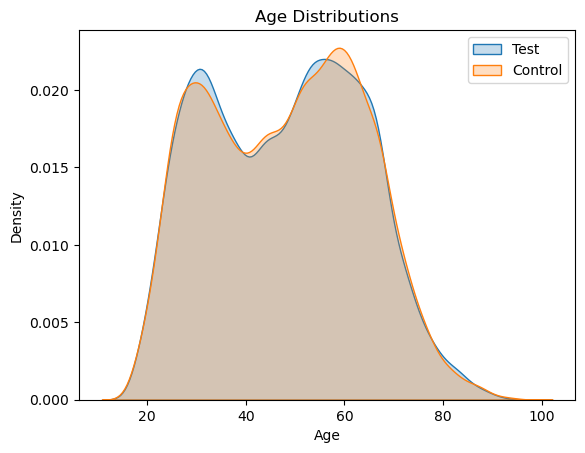

In [253]:
sns.kdeplot(visit_client[visit_client['Variation'] == 'Test']['clnt_age'], label='Test', fill=True)
sns.kdeplot(visit_client[visit_client['Variation'] == 'Control']['clnt_age'], label='Control', fill=True)

plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distributions')
plt.legend()
plt.show
plt.savefig("../figures/age_dist_control_vs_test.png", transparent=True)

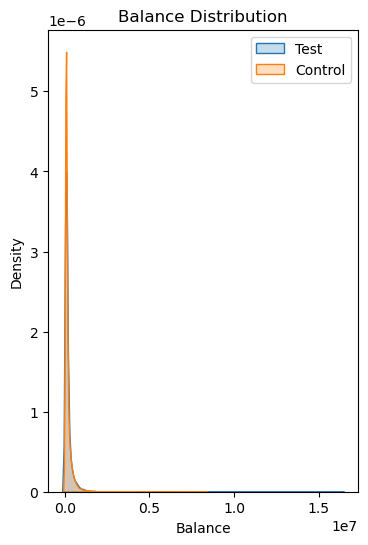

In [265]:
plt.figure(figsize=(4, 6))

sns.kdeplot(visit_client[visit_client['Variation'] == 'Test']['bal'], label='Test', fill=True)
sns.kdeplot(visit_client[visit_client['Variation'] == 'Control']['bal'], label='Control', fill=True)

plt.xlabel('Balance')
plt.ylabel('Density')
plt.title('Balance Distribution')
plt.legend()
plt.show
plt.savefig("../figures/bal_dist_control_vs_test.png", transparent=True)

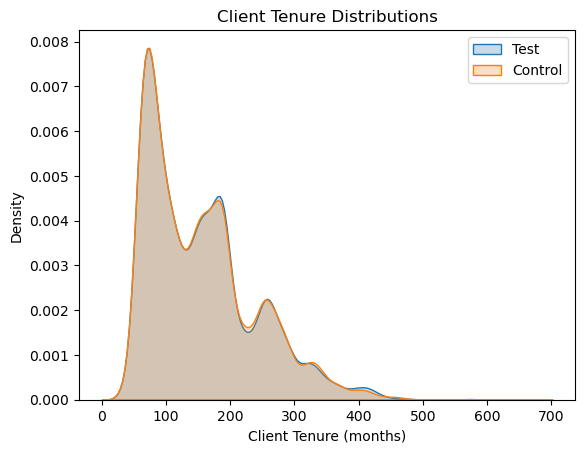

In [257]:
sns.kdeplot(visit_client[visit_client['Variation'] == 'Test']['clnt_tenure_mnth'], label='Test', fill=True)
sns.kdeplot(visit_client[visit_client['Variation'] == 'Control']['clnt_tenure_mnth'], label='Control', fill=True)

plt.xlabel('Client Tenure (months)')
plt.ylabel('Density')
plt.title('Client Tenure Distributions')
plt.legend()
plt.show
plt.savefig("../figures/clnt_tenure_dist_control_vs_test.png", transparent=True)

In [ ]:
# Is clnt_tenure_mnth similar between Test and Control

In [ ]:
# Is bal similar between Test and Control